In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# GPy: Gaussian processes library
import GPy

In [2]:
X = np.asarray([[2,3,3,3],[2,3,3,7],[2,3,7,3],[2,3,7,7], #[t_lower,t_upper,x_location,y_location]
               [8,9,3,3],[8,9,3,7],[8,9,7,3],[8,9,7,7]])

In [3]:
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging (second argument)

In [4]:
k_0 = 0.01 #Diffusion coefficient
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
kForward = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
u=[]
u.append(np.ones(res)*0.01) #x direction wind
u.append(np.ones(res)*0.01) # y direction wind

In [5]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,u=u,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
sourceGT = np.zeros(m.resolution)
sourceGT[:,7:11,7:11] = 10.0 # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

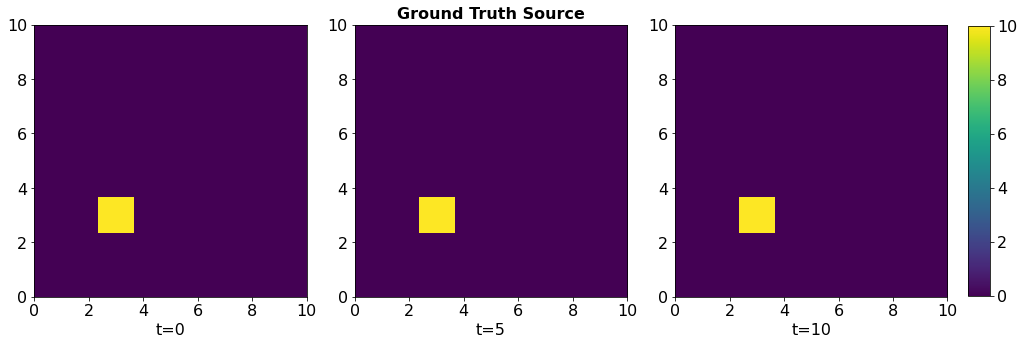

In [6]:
a=np.floor(np.min((np.min(sourceGT[[0,28,49]]))))
b=np.ceil(np.max((np.max(sourceGT[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source'],[sourceGT]):
    for t in [0,25,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = np.linspace(0,10,50)[t]
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

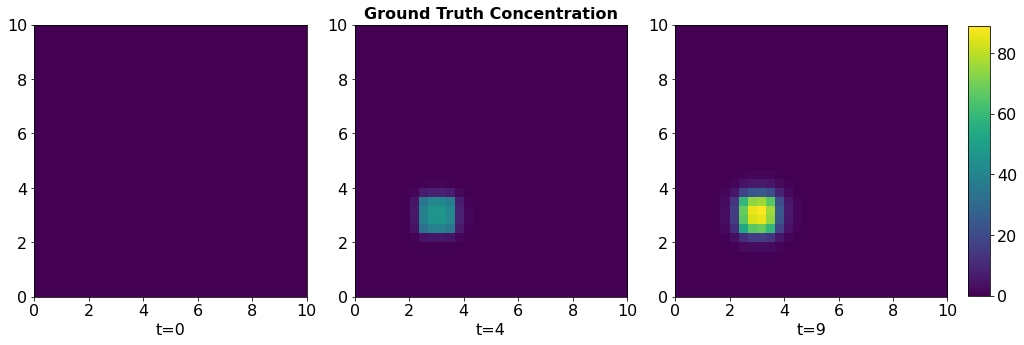

In [7]:
a=np.floor(np.min((np.min(concTrain[[0,28,49]]))))
b=np.ceil(np.max((np.max(concTrain[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Concentration'],[concTrain]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

# GP Inverse problem

In [8]:
kGP = GPy.kern.RBF(3, name="rbf")

In [9]:
XGP= np.zeros((8,3))

In [10]:
XGP[:,0] = (X[:,0]+X[:,1])/2
XGP[:,1] = X[:,2]
XGP[:,2] = X[:,3]

In [11]:
mGP = GPy.models.GPRegression(XGP, yTrain[:,None], kGP)
mGP 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [12]:
tt=np.linspace(m.boundary[0][0],m.boundary[1][0],m.resolution[0])
xx=np.linspace(m.boundary[0][1],m.boundary[1][1],m.resolution[1])
yy=np.linspace(m.boundary[0][2],m.boundary[1][2],m.resolution[2])
coords=np.asarray(np.meshgrid(tt,xx,yy,indexing='ij'))
m.coords.transpose().reshape(50*30*30,3)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.20408163,  0.        ,  0.        ],
       [ 0.40816327,  0.        ,  0.        ],
       ...,
       [ 9.59183673, 10.        , 10.        ],
       [ 9.79591837, 10.        , 10.        ],
       [10.        , 10.        , 10.        ]])

In [13]:
meanGP, Cov = mGP.predict_noiseless(m.coords.transpose().reshape(50*30*30,3), full_cov=True)
meanGP=meanGP.reshape(30,30,50).transpose()

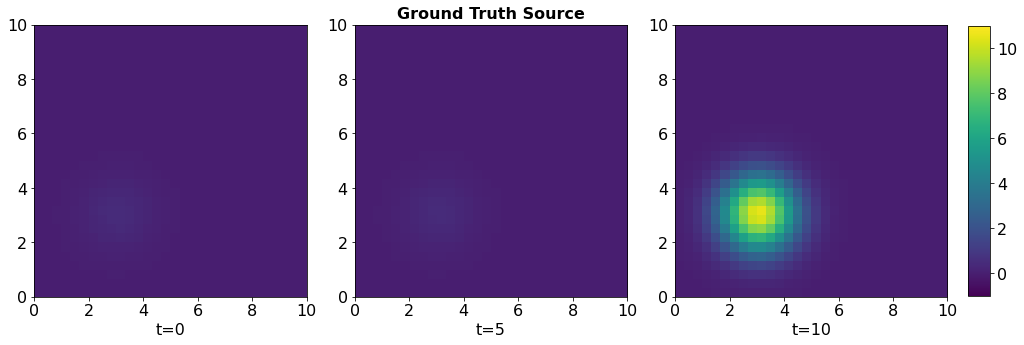

In [14]:
a=np.floor(np.min((np.min(meanGP[[0,28,49]]))))
b=np.ceil(np.max((np.max(meanGP[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source'],[meanGP]):
    for t in [0,25,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = np.linspace(0,10,50)[t]
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()